In [966]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [967]:
file = open('./.env')
api = file.read()

In [968]:
def search_igdb(n): 
  
    #set up an empty list to append each API call
    output = []
    url = 'https://api-v3.igdb.com/games/?limit=50'
    #establish URL and api_key
    headers = {
    'user-key': api,
    'accept': 'application/json'
     }
    #loops through a list of n length and updates offset after each call
    for i in list(range(n)): 
        offset = 0
        offset += 50*i 
        url_params = {
            'fields':'name, total_rating_count, total_rating, rating_count, rating, popularity, aggregated_rating, aggregated_rating_count, themes, platforms, first_release_date, player_perspectives, hypes, game_modes, game_engines, genres', 
            #'filter[release_dates.platform][any]': '48,49,6',
            'filter[total_rating_count][gte]': '150',
            'filter[rating_count][gte]': '100',
            'filter[aggregated_rating_count][gte]': '10',
            'offset': offset
      
      
      
    #         'filter'= filter[release_dates.platform][any] = 48,49,6
    #         'filter'= filter[total_rating_count][gte] = 1
          }
        #fields=*&filter[release_dates.platform][any]=48,49,6
    
    
        response = requests.get(url, headers=headers, params=url_params)
        #run our request get requests
    
  
    
        list(filter(lambda x: output.append(x), response.json()))
     #and 
  
    return output

In [969]:
video_games = search_igdb(4)
df = pd.DataFrame(video_games)

In [970]:
# sort the games by the highest rating 
df = df.sort_values('total_rating', ascending=False)

In [971]:
# change the index of the DataFrame to the name of the game
df = df.set_index('name')

In [972]:
# drop the column with the game 'IDs'
df = df.drop(['id'], axis=1)

In [973]:
# changing column names
df = df.rename(columns={'aggregated_rating':'critic_review_rating'})
df = df.rename(columns={'aggregated_rating_count':'critic_review_count'})
df = df.rename(columns={'first_release_date':'release_date'})
df = df.rename(columns={'rating':'player_review_rating'})
df = df.rename(columns={'rating_count':'player_review_rating_count'})
df = df.rename(columns={'total_rating':'total_review_rating'})
df = df.rename(columns={'total_rating_count':'total_review_rating_count'})

In [974]:
# replace the values in our two rows with 
for row in df.loc[df.themes.isnull(), 'themes'].index: 
    df.at[row, 'themes'] = [] 
        
for row in df.loc[df.player_perspectives.isnull(), 'player_perspectives'].index: 
    df.at[row, 'player_perspectives'] = [] 

In [975]:
df = df.fillna(' ')

In [976]:
# getting codes for each column 

platforms_codes = list(df['platforms'])
game_engines_codes = list(df['game_engines'])
player_perspectives_codes = list(df['player_perspectives'])
game_modes_codes = list(df['game_modes'])
themes_codes = list(df['themes'])

def unique_column_set(column):
    unique_letters = [] 
    for letters in column:
        for letter in letters:
            if letters != '':
                unique_letters.append(letter)
    return set(unique_letters)

unique_platforms_codes = unique_column_set(platforms_codes)
unique_game_engines_codes = unique_column_set(game_engines_codes)
unique_player_perspectives_codes = unique_column_set(player_perspectives_codes)
unique_game_modes_codes = unique_column_set(game_modes_codes)
unique_themes_codes = unique_column_set(themes_codes)

In [977]:
# getting all the values for release_dates in a unique set

unix_codes = list(df['release_date'])

def unique_release_set(lst):
    unique_dates = [] 
    for date in lst:
                unique_dates.append(date)
    return set(unique_dates)

unique_release_codes = unique_release_set(unix_codes)

In [978]:
# converting epoch to human readable date
df['release_date'] = pd.to_datetime(df['release_date'], unit='s')

In [979]:
# creating a new column called year which displays just the year the game released in standart date time
df['release_year'] = df['release_date'].dt.year

In [980]:
# round off the digits by 2 decimal places
df['critic_review_rating']= round(df['critic_review_rating'], 2)
df['popularity']= round(df['popularity'], 2)
df['player_review_rating']= round(df['player_review_rating'], 2)
df['player_review_rating_count']= round(df['player_review_rating_count'], 2)
df['total_review_rating']= round(df['total_review_rating'], 2)

In [981]:
# created dictionary with keys as game_mode and values as the corresponding ID
game_modes = {'Single Player':1, 
              'Multiplayer':2 , 
              'Co-operative':3, 
              'Split Screen':4, 
              'Massively Multiplayer Online':5}  

In [982]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [983]:
#goes through our series function game_modes and creates a new set of columns that passes a boolean True if that game supports that game mode
for game_mode in game_modes.keys():
    df[game_mode] = df.game_modes.apply(lambda mode_list: game_modes[game_mode] in mode_list)

In [984]:
#created dictionary with keys as platform and values as corresponding ID for each platform
platforms = {'Linux': 3,
'Wii': 5 ,
'PC': 6,
'PS3': 9,
'Xbox': 11,
'Xbox 360':12,
'Mac': 14,
'Nintendo DS':20,
'Android':34,
'Xbox Live Arcade':36,
'Nintendo 3DS': 37,
'iOS':39,
'Wii U':41,
'PlayStation Network':45,
'PlayStation Vita':46,
'PS4':48,
'Xbox One':49,
'Arcade':52,
'Ouya':72,
'Windows Phone':74,
'SteamOS':92,
'Nintendo Switch':130,
'Nintendo DSi':159}

In [985]:
#goes through each list in the platform column and creates a dummy variable for each platform type and adds a boolean expression if the game in question is offered on that platform
for platform in platforms.keys():
    df[platform] = df.platforms.apply(lambda plat_list: platforms[platform] in plat_list) 

In [986]:
themes = {'Action':1,
    'Fantasy': 17,
    'Science-Fiction': 18,
    'Horror': 19,
    'Thriller': 20,
    'Survival': 21,
    'Historical': 22,
    'Stealth': 23,
    'Comedy': 27,
    'Business': 28,
    'Drama': 31,
    'Non-Fiction': 32,
    'Sandbox': 33,
    'Educational': 34,
    'Kids': 35,
    'Open-world': 38,
    'Warfare': 39,
    'Erotic': 42,
    'Mystery': 43 }

In [987]:
#perform the repeated for loop on the them column and then drop the theme column
for theme in themes.keys():
    df[theme] = df.themes.apply(lambda theme_list: themes[theme] in theme_list)

In [988]:
#repeat for player_perspectives
player_perspectives = {'First-Person':1,
    'Third-Person': 2,
    'Bird-view': 3,
    'Side-view': 4,
    'Text': 5,
    'Aural': 6,
    'Virtual Reality': 7}

In [989]:

for player_perspective in player_perspectives.keys():
    df[player_perspective] = df.player_perspectives.apply(lambda pp_list: player_perspectives[player_perspective] in pp_list)

In [990]:
#repeating the process for genres defining our dictionary
genres = {'Simulator':13,
'Tactical':24,
'Quiz/Trivia':26,
'Fighting':4,
'Strategy':15,
'Adventure':31,
'Role-playing (RPG)':12,
'Shooter':5,
'Music':7,
'Indie':32,
'Turn-based strategy (TBS)':16,
'Pinball':30,
'Puzzle':9,
'Real Time Strategy (RTS)':11,
'Hack and slash/Beat ’em up':25,
'Platform':8,
'Racing':10,
'Sport':14,
'Arcade':33,
'Point-and-click':2}

In [991]:
#probably could have came up with a function for this
for genre in genres.keys():
    df[genre] = df.genres.apply(lambda genre_list: genres[genre] in genre_list)

In [992]:
### Drop each column
df = df.drop(['platforms'], axis=1) 

In [993]:
df = df.drop(['genres'], axis=1) 

In [994]:
df = df.drop(['game_modes'], axis=1)

In [995]:
df = df.drop(['player_perspectives'], axis=1)

In [996]:
df = df.drop(['themes'], axis=1)
###

In [997]:
df.head(100)

,critic_review_rating,critic_review_count,release_date,game_engines,hypes,popularity,player_review_rating,player_review_rating_count,total_review_rating,total_review_rating_count,...,Indie,Turn-based strategy (TBS),Pinball,Puzzle,Real Time Strategy (RTS),Hack and slash/Beat ’em up,Platform,Racing,Sport,Point-and-click
name,,,,,,,,,,,,,,,,,,,,,
God of War,96.94,21,2018-04-20,,92,114.38,96.30,378,96.62,399,...,False,False,False,False,False,False,False,False,False,False
Red Dead Redemption 2,95.92,22,2018-10-26,[26],257,219.02,96.99,207,96.45,229,...,False,False,False,False,False,False,False,False,False,False
The Last of Us Remastered,97.40,11,2014-07-29,,5,25.62,93.22,465,95.31,476,...,False,False,False,False,False,False,False,False,False,False
The Legend of Zelda: Breath of the Wild,97.59,31,2017-03-03,"[17, 502, 503]",142,66.11,92.58,469,95.09,500,...,False,False,False,False,False,False,False,False,False,False
Super Mario Odyssey,96.71,19,2017-10-27,,88,34.37,91.95,280,94.33,299,...,False,False,False,False,False,False,True,False,False,False
Persona 5,93.57,23,2016-09-15,,34,51.21,94.83,163,94.20,186,...,False,False,False,False,False,False,True,False,False,False
Mass Effect 2,95.60,14,2010-01-26,[351],1,25.30,92.76,1018,94.18,1032,...,False,False,False,False,False,False,False,False,False,False
The Witcher 3: Wild Hunt,91.72,26,2015-05-19,[24],179,111.79,96.38,1370,94.05,1396,...,False,False,False,False,False,False,False,False,False,False
Grand Theft Auto V,95.84,34,2013-09-17,[26],,84.90,92.00,1628,93.92,1662,...,False,False,False,False,False,False,False,True,True,False


# Did video games get better or worse overtime?

In [998]:
# mean values for all columns by release_year
release_year_mean = df.groupby(['release_year']).mean()

Text(0.5, 1.0, 'Average rating of the top games by year')

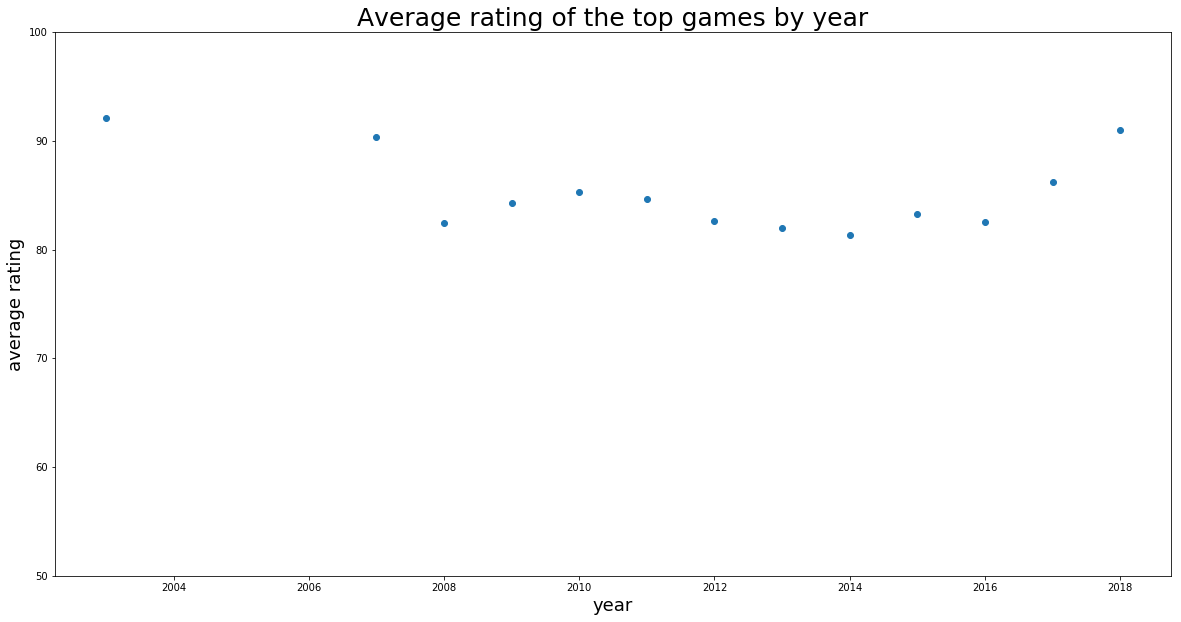

In [999]:
new_figure = plt.figure(figsize=(20, 10))
ax = new_figure.add_subplot(111)
ax.scatter(release_year_mean.index , release_year_mean.total_review_rating)
ax.set_xlabel('year', size=18)
ax.set_ylabel('average rating', size=18)
ax.set_ylim(50,100)
ax.set_title('Average rating of the top games by year', size=25)

In [1000]:
df['Xbox One'].mean()
df['Xbox 360'] 

name
God of War                                    False
Red Dead Redemption 2                         False
The Last of Us Remastered                     False
The Legend of Zelda: Breath of the Wild       False
Super Mario Odyssey                           False
Persona 5                                     False
Mass Effect 2                                  True
The Witcher 3: Wild Hunt                      False
Grand Theft Auto V                             True
The Witcher 3: Wild Hunt - Blood and Wine     False
Super Mario Galaxy 2                          False
The Last of Us                                False
Uncharted 2: Among Thieves                    False
Undertale                                     False
Uncharted 4: A Thief's End                    False
The Elder Scrolls V: Skyrim                    True
Star Wars: Knights of the Old Republic        False
The Witcher 3: Wild Hunt - Hearts of Stone    False
Portal 2                                       True
Horizon

In [1001]:
#get the mean for each column of relevant dummy variables for each of the three major gaming platforms

xbox = df[(df["Xbox One"] == True) | (df["Xbox"] == True) | (df["Xbox 360"] == True) | (df["Xbox Live Arcade"] == True)].mean()




#get the fraction of games for each major platform that fall into one of the column
ps = df[(df["PlayStation Vita"] == True) | (df["PS3"] == True) | (df["PS4"] == True) | (df["PlayStation Network"] == True)].mean()



#get the fraction of games for each major platform that fall into one of the column
nintendo = df[(df["Nintendo DS"] == True) | (df["Wii"] == True) | (df["Wii U"] == True) | (df["Nintendo 3DS"] == True) | (df["Nintendo DSi"] == True) | (df["Nintendo Switch"] == True)].mean()

In [1002]:
x_xbox

['Simulator',
 'Tactical',
 'Quiz/Trivia',
 'Fighting',
 'Strategy',
 'Adventure',
 'RPG',
 'Shooter',
 'Music',
 'Indie',
 'TBS',
 'Pinball',
 'Puzzle',
 'RTS',
 'Beat em up',
 'Platform',
 'Racing',
 'Sport',
 'Point-and-click']

In [1003]:
#needed to make a list of every game that is offered on all Xbox platforms
list_of_xbox_games = []

list_of_xbox_games = df.index[df['Xbox 360'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox One'] == True].tolist()
list_of_xbox_games += df.index[df['Xbox Live Arcade'] == True].tolist()


#because games can be offered on more than one needed to create a unique list
unique_ls_xbox_games = list(set(list_of_xbox_games))


#now have a list of xbox games
len(unique_ls_xbox_games)


###repeat this for Playstation and Nintendo####

list_of_playstation_games = []

list_of_playstation_games = df.index[df['PS3'] == True].tolist()
list_of_playstation_games += df.index[df['PS4'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Vita'] == True].tolist()
list_of_playstation_games += df.index[df['PlayStation Network'] == True].tolist()


unique_ls_playstation_games = list(set(list_of_playstation_games))

len(unique_ls_playstation_games)




list_of_nintendo_games = []

list_of_nintendo_games = df.index[df['Wii'] == True].tolist()
list_of_nintendo_games += df.index[df['Wii U'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo 3DS'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo Switch'] == True].tolist()
list_of_nintendo_games += df.index[df['Nintendo DSi'] == True].tolist()


unique_ls_nintendo_games = list(set(list_of_nintendo_games))

len(unique_ls_nintendo_games)


41

In [1004]:
%matplotlib inline
!pip install matplotlib-venn

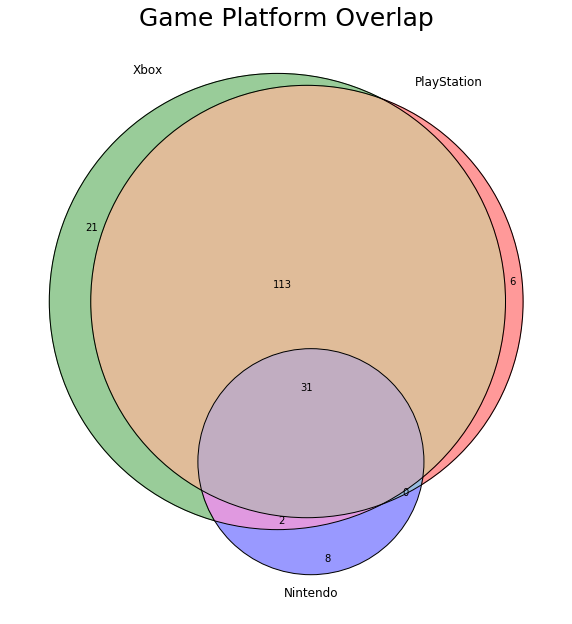

In [1022]:
#given the unique assemblance of my data this takes in area.weight inputs and returns a venn-diagram 
from matplotlib import pyplot as plt
import numpy as np
from matplotlib_venn import venn3, venn3_circles
#need to find the overlap of games between each video game platform so convert our unique list of games offered for each platform into a set
A = unique_ls_playstation_games
B = unique_ls_xbox_games
C = unique_ls_nintendo_games
Abc = len(set(A)-set(B)-set(C)) 
aBc = len(set(B)-set(A)-set(C)) 
ABc = len(set(A)&set(B)-set(C)) 
abC = len(set(C)-set(A)-set(B)) 
AbC = len(set(A)&set(C)-set(B)) 
aBC = len(set(B)&set(C)-set(A)) 
ABC = len(set(A)&set(B)&set(C)) 
#using the lengths of the unique list that we set up earlier and checking the overlap between them using the bitwise operators we can create a list of area weighted overlaps for each section of our venn diagram 
#the set of values that it takes will be the weighted average of every combination of game_overlap
plt.figure(figsize=(10,15))
v = venn3(subsets=((Abc, aBc, ABc, abC, AbC, aBC, ABC)), set_labels = ('Xbox', 'PlayStation', 'Nintendo'))
c=venn3_circles(subsets = (Abc, aBc, ABc, abC, AbC, aBC, ABC), linestyle='solid', linewidth=1, color="black")
v.get_patch_by_id('A').set_color('green')
v.get_patch_by_id('B').set_color('red')
plt.title('Game Platform Overlap', size = 25)
plt.show()

In [1006]:
#create a list of x values that correspond to the fraction of Playstation games by genre
y_ps = [ps['Simulator'], ps['Tactical'],
        ps['Quiz/Trivia'], ps['Fighting'], ps['Strategy'], ps['Adventure'],
        ps['Role-playing (RPG)'], ps['Shooter'], ps['Music'], ps['Indie'],
        ps['Turn-based strategy (TBS)'], ps['Pinball'], ps['Puzzle'],
        ps['Real Time Strategy (RTS)'], ps['Hack and slash/Beat ’em up'], ps['Platform'],
        ps['Racing'], ps['Sport'], ps['Point-and-click']]




#create a list of y values that corresponds to the name of each genre
x_ps = ['Simulator', 'Tactical','Quiz/Trivia', 
        'Fighting', 'Strategy', 'Adventure','RPG', 
        'Shooter', 'Music', 'Indie','TBS', 'Pinball', 
        'Puzzle','RTS','Beat em up', 'Platform','Racing', 
        'Sport','Point-and-click']

In [1007]:
#create a list of x values that correspond the breakdown of Playstation games by genre

y_xbox = [xbox['Simulator'],xbox['Tactical'],
          xbox['Quiz/Trivia'], xbox['Fighting'], xbox['Strategy'], xbox['Adventure'],
          xbox['Role-playing (RPG)'], xbox['Shooter'], xbox['Music'], xbox['Indie'],
          xbox['Turn-based strategy (TBS)'], xbox['Pinball'], xbox['Puzzle'],
          xbox['Real Time Strategy (RTS)'], xbox['Hack and slash/Beat ’em up'], xbox['Platform'],
          xbox['Racing'], xbox['Sport'], xbox['Point-and-click']]
             
             


             
x_xbox = ['Simulator', 'Tactical',
          'Quiz/Trivia', 'Fighting', 'Strategy', 'Adventure',
          'RPG', 'Shooter', 'Music', 'Indie',
          'TBS', 'Pinball', 'Puzzle',
          'RTS','Beat em up', 'Platform',
          'Racing', 'Sport','Point-and-click']

In [1008]:
#create a list of x values that correspond the breakdown of Playstation games by genre
y_nintendo = [
       nintendo['Simulator'], nintendo['Tactical'],
       nintendo['Quiz/Trivia'], nintendo['Fighting'], nintendo['Strategy'], nintendo['Adventure'],
       nintendo['Role-playing (RPG)'], nintendo['Shooter'], nintendo['Music'], nintendo['Indie'],
       nintendo['Turn-based strategy (TBS)'], nintendo['Pinball'], nintendo['Puzzle'],
       nintendo['Real Time Strategy (RTS)'], nintendo['Hack and slash/Beat ’em up'], nintendo['Platform'],
       nintendo['Racing'], nintendo['Sport'], nintendo['Point-and-click']
]

                   
x_nintendo = [
        'Simulator', 'Tactical',
        'Quiz/Trivia', 'Fighting', 'Strategy', 'Adventure',
        'RPG', 'Shooter', 'Music', 'Indie',
        'TBS', 'Pinball', 'Puzzle',
        'RTS','Beat em up', 'Platform',
        'Racing', 'Sport','Point-and-click'
]

In [1009]:
#create a list of y values that corresponds to the name of each genre
#need to find a way to transform numpy.float value into usable integer
help(new_figure.add_subplot)

Help on method add_subplot in module matplotlib.figure:

add_subplot(*args, **kwargs) method of matplotlib.figure.Figure instance
    Add an `~.axes.Axes` to the figure as part of a subplot arrangement.
    
    Call signatures::
    
       add_subplot(nrows, ncols, index, **kwargs)
       add_subplot(pos, **kwargs)
       add_subplot(ax)
    
    Parameters
    ----------
    *args
        Either a 3-digit integer or three separate integers
        describing the position of the subplot. If the three
        integers are *nrows*, *ncols*, and *index* in order, the
        subplot will take the *index* position on a grid with *nrows*
        rows and *ncols* columns. *index* starts at 1 in the upper left
        corner and increases to the right.
    
        *pos* is a three digit integer, where the first digit is the
        number of rows, the second the number of columns, and the third
        the index of the subplot. i.e. fig.add_subplot(235) is the same as
        fig.add_subpl

Text(0.5, 1.0, "Playstation's Game Breakdown By Genre")

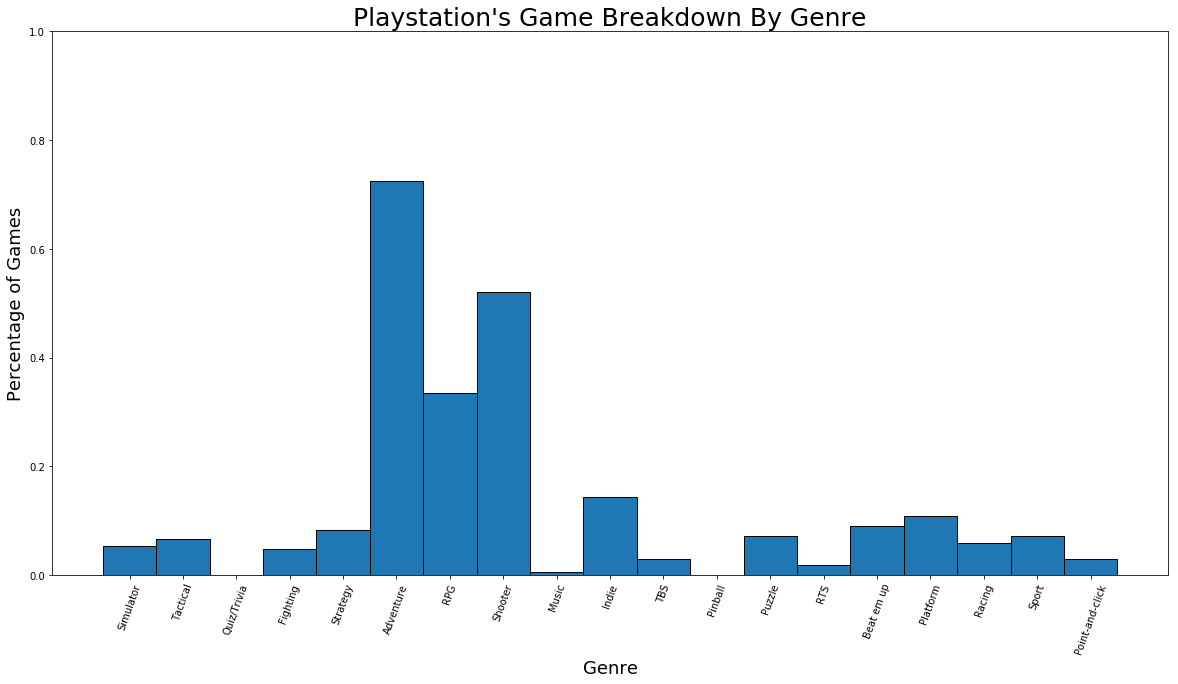

In [1010]:
new_figure_1= plt.figure(figsize=(20,10))
ax = new_figure_1.add_subplot(111, ylim = (0.0, 1.0))
ax.bar(x_ps, y_ps, width=1, bottom=None, edgecolor = 'black', linewidth = 1)
ax.set_xticklabels(x_ps, rotation=70)
ax.set_xlabel('Genre', size=18)
ax.set_ylabel('Percentage of Games', size = 18)
ax.set_title("Playstation's Game Breakdown By Genre", size=25)

Text(0.5, 1.0, 'Xbox Game Breakdown By Genre')

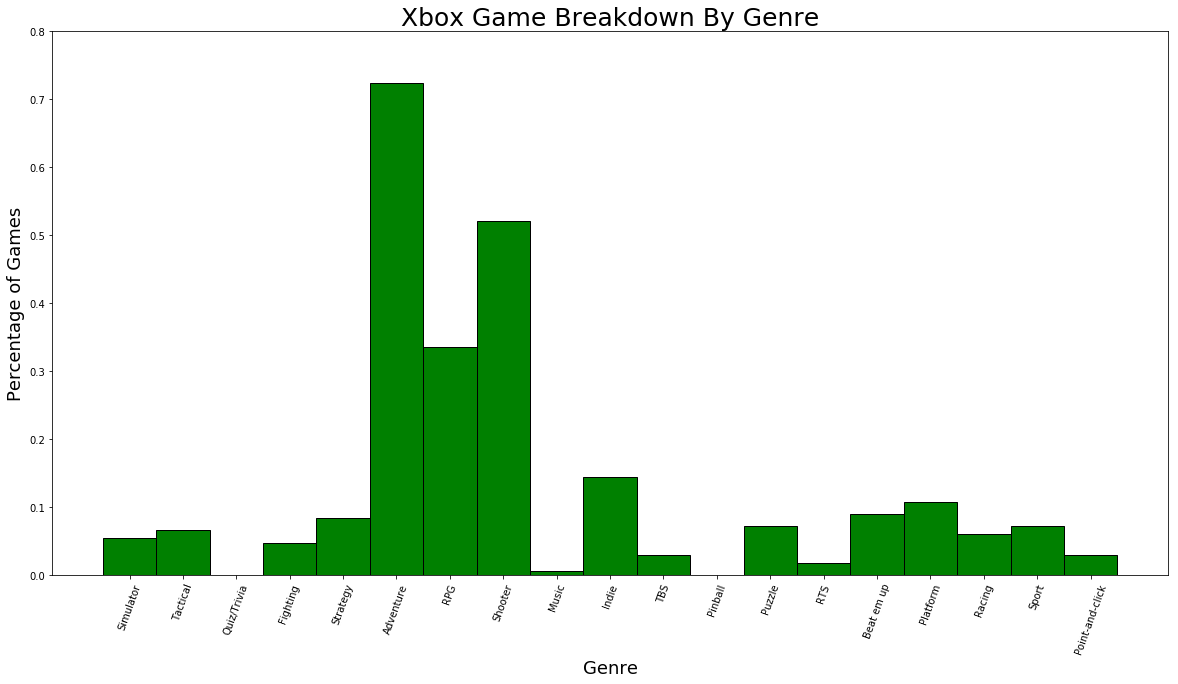

In [1011]:
new_figure_2= plt.figure(figsize=(20, 10))
ax2 = new_figure_2.add_subplot(111, ymargin=.01, ylim = (0.0, .8))
ax2.bar(x_ps, y_ps, width=1, bottom=None, edgecolor = 'black', linewidth = 1, color = 'green')
ax2.set_xticklabels(x_ps, rotation=70)
ax2.set_xlabel('Genre', size=18)
ax2.set_ylabel('Percentage of Games', size = 18)
ax2.set_title("Xbox Game Breakdown By Genre", size=25)

Text(0.5, 1.0, "Nintendo's Game Breakdown By Genre")

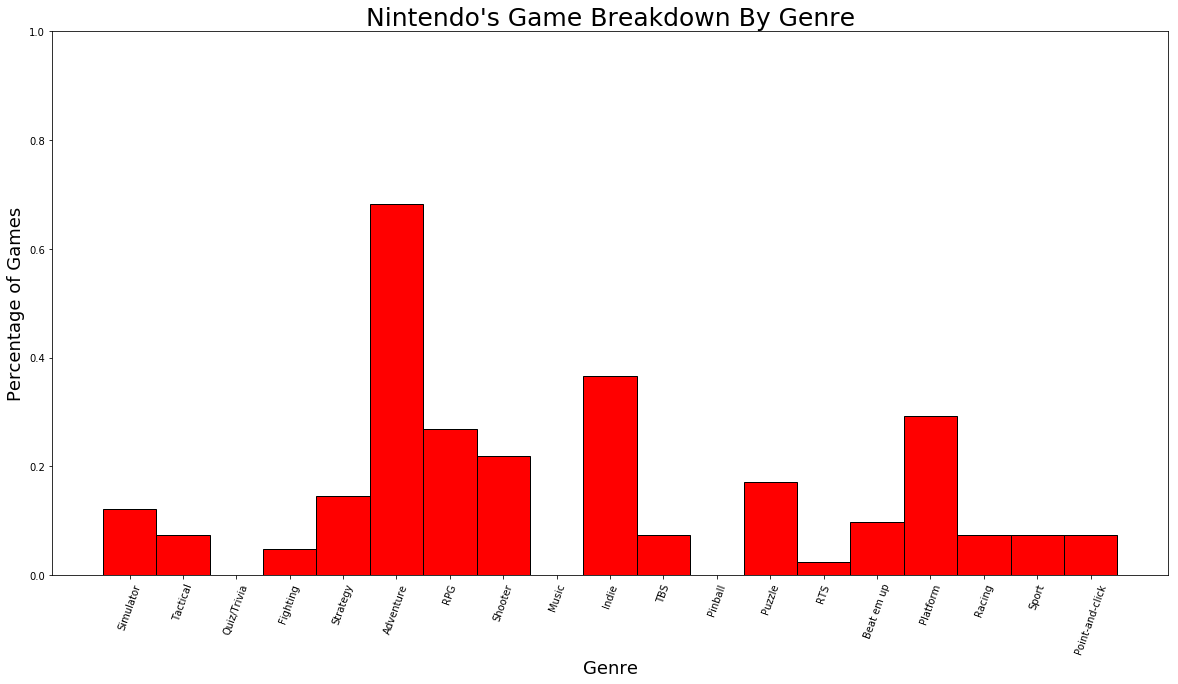

In [1012]:
new_figure_3 = plt.figure(figsize=(20,10))
ax3 = new_figure_3.add_subplot(111, ymargin=.01, ylim = (0.0, 1.0))
ax3.bar(x_nintendo, y_nintendo, width=1, bottom=None, edgecolor = 'black', linewidth = 1, color='red')
ax3.set_xticklabels(x_ps, rotation=70)
ax3.set_xlabel('Genre', size=18)
ax3.set_ylabel('Percentage of Games', size = 18)
ax3.set_title("Nintendo's Game Breakdown By Genre", size=25)